#### All important imports 

In [19]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
from openpyxl import Workbook
import os
import ipdb
from scipy.interpolate import griddata
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt


# 1. Script for clipping data

In [3]:
def get_clean_state_name(shapefile_path):
    state = os.path.basename(shapefile_path)  # Get the base file name
    state = state.split('.')[0]  # Remove the file extension
    if state.endswith("_buffer"):
        state = state[:-7]  # Remove "_buffer" if present
    return state
def clip_data_by_bbox(AphoditeDataAdress, shapefilePath, ClippedFolderPath):
    # Read the shapefile
    # print(shapefilePath)
    gdf = gpd.read_file(shapefilePath)
    # ipdb.set_trace()
    # Get the geometry
    geometry = gdf['geometry']
    # Get the bounding box
    bbox = geometry.bounds
    # Get the coordinates
    xmin = bbox['minx'][0]
    xmax = bbox['maxx'][0]
    ymin = bbox['miny'][0]
    ymax = bbox['maxy'][0]

    #Masking
    # Open the NetCDF dataset using xarray
    ds = xr.open_dataset(AphoditeDataAdress)
    # Define the latitude and longitude variable names to check
    possible_lat_names = ['lat', 'latitude', 'Latitude', 'LAT', 'LATITUDE', 'Lat']
    possible_lon_names = ['lon', 'longitude', 'Longitude', 'LON', 'LONGITUDE', 'Lon']

    # Initialize variables to None
    lat_var = None
    lon_var = None

    # Try to find the latitude and longitude variables
    for lat_name in possible_lat_names:
        if lat_name in ds.variables:
            lat_var = ds[lat_name]
            break

    for lon_name in possible_lon_names:
        if lon_name in ds.variables:
            lon_var = ds[lon_name]
            break

    # Apply the mask to latitude and longitude using xarray indexing
    mask_lat = (lat_var >= ymin) & (lat_var <= ymax)
    mask_lon = (lon_var >= xmin) & (lon_var <= xmax)
    # ipdb.set_trace()
    if not mask_lat.any() or not mask_lon.any():
        return None 
    data = ds.where(mask_lat & mask_lon, drop=True)
    # dataset = regionmask.Regions(name='State_Name', numbers=[0], names=gdf.State_Name[[0]], abbrevs=gdf.State[[0]], outlines=gdf.geometry[[0]])
    # Provide the correct file path

    # Finding name of state to save with
    stateName = get_clean_state_name(shapefilePath)
    Year = AphoditeDataAdress.split('.')[-2]
    #APHRO_MA_025deg_V1101.2006.nc --> extract 2006

    # Construct the filename with stateName_Year.nc
    ClippedDataFile = f"{stateName}_{Year}.nc"
    # Construct full path for saving the CSV file
    nc_file_path  = os.path.join(ClippedFolderPath, ClippedDataFile)
    data.to_netcdf(nc_file_path)
    # Save the .nc file for each indiividual state, for all years individually

def do_Clipping_Statewise(shapefilePath, AphoditeDataAdress, ClippedFolderPath,state):
    for dataset in os.listdir(AphoditeDataAdress):
        datasetPath = os.path.join(AphoditeDataAdress,dataset)
        clip_data_by_bbox(datasetPath, shapefilePath, ClippedFolderPath)


shapeFileAddress =['./Buffer_Boundary/J&K/J&K.shp',
                  './Buffer_Boundary/AP/AP_buffer.shp',
                  './Buffer_Boundary/HP/HP_buffer.shp',
                  './Buffer_Boundary/SK/SK_buffer.shp',
                  './Buffer_Boundary/UK/UK_buffer.shp']

# shapeFileAddress1 = ['./Buffer_Boundary/Jammu&Kashmir/J&K.shp']
AphoditeDataAdress = "./PrecipData"
ClippedFolderPath = "./PrecipitaionAnalysis/ClippedData"


for file in (shapeFileAddress):
    shapefilePath = file

    state = get_clean_state_name(shapefilePath)
    statefolder = ClippedFolderPath + '/' + state
    if not os.path.exists(statefolder):#make state folder name if not exists
        os.makedirs(statefolder)
    print(f'---Clipping started for --{state}-------------------------------')
    do_Clipping_Statewise(shapefilePath, AphoditeDataAdress, statefolder, state)
    print(f'---Clipping completed for --{state}-------------------------------')

    

---Clipping started for --J&K-------------------------------
---Clipping completed for --J&K-------------------------------
---Clipping started for --AP-------------------------------
---Clipping completed for --AP-------------------------------
---Clipping started for --HP-------------------------------
---Clipping completed for --HP-------------------------------
---Clipping started for --SK-------------------------------
---Clipping completed for --SK-------------------------------
---Clipping started for --UK-------------------------------
---Clipping completed for --UK-------------------------------


Time taken = 2 min 20 sec

# 2. YEARLY PRECIPITATION
#### SUM OF ALL NC FILES YEARWISE AND STORE INTO ONE CSV FILE

In [5]:
def get_clean_state_nameYear(shapefile_path):
    state = os.path.basename(shapefile_path)  # Get the base file name
    state,year = state.split('.')  # Remove the file extension
    if state.endswith("_buffer"):
        state = state[:-7]  # Remove "_buffer" if present
    return state, year
def DoPrecipSumtoCsv(clipfile, csvfolder):

    # Open the NetCDF file using xarray
    nc_file = xr.open_dataset(clipfile)

    # Initialize a list to store dictionaries for each point
    summed_data = []
    # Define the variable names for latitude and longitude
    lat_var_names = ['lat', 'latitude', 'Latitude', 'LAT', 'LATITUDE', 'Lat']
    lon_var_names = ['lon', 'longitude', 'Longitude', 'LON', 'LONGITUDE', 'Lon']

    # Initialize variables to None
    lat_var = None
    lon_var = None

    # Try to find the latitude and longitude variables
    for lat_name in lat_var_names:
        if lat_name in nc_file.variables:
            lat_var = nc_file[lat_name]
            break

    for lon_name in lon_var_names:
        if lon_name in nc_file.variables:
            lon_var = nc_file[lon_name]
            break
    
    #finding year for current clipfile
    baseFileName = os.path.basename(clipfile)
    name, extensions = baseFileName.split('.')
    name, year = name.split('_') 
    # Check if latitude and longitude variables were found
    # if lat_var is not None and lon_var is not None:
    # Extract latitude and longitude values from the file
    lats = lat_var.values
    lons = lon_var.values
    # Loop through each combination of latitude and longitude
    for lat in lats:
        for lon in lons:
            # Find the indices corresponding to the current latitude and longitude
            lat_idx = np.argmin(np.abs(lats - lat))
            lon_idx = np.argmin(np.abs(lons - lon))

            # Extract precipitation 
            precip = nc_file['precip'][:, lat_idx, lon_idx]
            # Calculate the sum of precipitation 
            total_precip = np.sum(precip.values)
            # Create a dictionary to store the data for the current point
            point_data = {
                'Latitude': lat,
                'Longitude': lon,
                f'Precip_{year}': total_precip,
            }

                # Append the dictionary to the list
            summed_data.append(point_data)

     # Convert the summed_data list to a pandas DataFrame
        df = pd.DataFrame(summed_data)

        # Construct the CSV filename based on the year
        csv_filename = os.path.join(csvfolder, f'{name}.csv')

        # Check if the CSV file already exists
        if os.path.exists(csv_filename):
            # If the file exists, open it
            existing_df = pd.read_csv(csv_filename)
            # Merge the existing DataFrame with the new data based on Latitude and Longitude
            df = pd.merge(existing_df, df, on=['Latitude', 'Longitude'], how='outer',suffixes=('_existing', '_new'))

        # Save the DataFrame to a CSV file
    df.to_csv(csv_filename, index=False)
    # Print or use the summed_data list as needed
    return
    # Print or use the summed_data list as needed   

csvfolder = './PrecipitaionAnalysis/ClippedCSV'
ClippedData = './PrecipitaionAnalysis/ClippedData'
# ipdb.set_trace()
for state in os.listdir(ClippedData):
    statePath =  ClippedData + '/' + state
    name = os.path.basename(statePath)
    print(f'---------{name}-----yearwise sum precipiation started------------------')
    if os.path.isdir(statePath):
    # Iterate through the files in the state directory
        for clipdata in os.listdir(statePath):
            clipfile = statePath + '/' + clipdata

            # Call your DoPrecipSum function to process the file
            DoPrecipSumtoCsv(clipfile, csvfolder)
    print(f'---{name}--csv file saved-------------------')
    
# it will go to each yearwise nc file and find the sum of precipitation for each point and save it in csv file

---------AP-----yearwise sum precipiation started------------------
---AP--csv file saved-------------------
---------HP-----yearwise sum precipiation started------------------
---HP--csv file saved-------------------
---------J&K-----yearwise sum precipiation started------------------
---J&K--csv file saved-------------------
---------SK-----yearwise sum precipiation started------------------
---SK--csv file saved-------------------
---------UK-----yearwise sum precipiation started------------------
---UK--csv file saved-------------------


Time = 58 sec

# 3. Doing interpolation

####  Interpolation methods
1. Bilinear Interpolation
2. Cubic Interpolation
3. Nearest Neighbour Interpolation
4. Inverse Distance Weightage Method (IDW)
5. Modified Inverse Distance Weightage Method (MIDW)



1. Cubic Interpolation:
- Description: Cubic interpolation is a method that uses piecewise third-degree polynomials to estimate values between known data points.
- Use Case: It is useful when you have smooth and continuous data with moderate variations. Cubic interpolation can be used for a wide range of applications, including computer graphics and engineering simulations.

2. Linear Interpolation:
- Description: Linear interpolation estimates values between two known data points by assuming a linear relationship.
- Use Case: It is commonly used for simple and quick estimations when you have data points that change linearly between two points. It's used in finance, simple graphics, and engineering.

3. IDW (Inverse Distance Weighting):
- Description: IDW is a spatial interpolation method that assigns values to unknown points based on the weighted average of values from nearby known points. The weights are inversely proportional to distance.
- Use Case: IDW is suitable for situations where the values have spatial correlation, such as environmental data, geology, or any data with spatial dependency.

4. MIDW (Modified Inverse Distance Weighting):
- Description: MIDW is an extension of IDW that modifies the weights used in the interpolation process, providing more control over the influence of nearby points.
- Use Case: MIDW is useful when you want to adjust the impact of nearby points and reduce the influence of outliers. It is often applied in geostatistics and spatial analysis.

5. Nearest Neighbor Interpolation:
- Description: Nearest neighbor interpolation assigns values to unknown points based on the value of the nearest known point. It is a simple and fast method.
- Use Case: Nearest neighbor interpolation is used when you want to find the closest known data point for each unknown point. This method is suitable for discrete data or classification problems.

 


##### For state SK
Number of missing values:
Linear =  1805,
Cubic =  1805,
Nearest =  0,
IDW =  0,
MIDW =  0

##### For state UK
Number of missing values: 
Linear =  0,
Cubic =  0,
Nearest =  0,
IDW =  0,
MIDW =  0,

##### For state J&K
Number of missing values: 
Linear =  0,
Cubic =  0,
Nearest =  0,
IDW =  0,
MIDW =  0,

##### For state AP
Number of missing values: 
Linear =  652,
Cubic =  652,
Nearest =  0,
IDW =  0,
MIDW =  0,

##### For state HP
Number of missing values: 
Linear =  165,
Cubic =  165,
Nearest =  0,
IDW =  0,
MIDW =  0

In [3]:
def BilinearInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    Interpolated_precip = griddata(
            (latitudes_precip, longitudes_precip),
            precipitation,
            (latitudes_timberline, longitudes_timberline),  # Use timberline lat/lon
            method='linear'
        )
    return Interpolated_precip
def CubicInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    Interpolated_precip = griddata(
            (latitudes_precip, longitudes_precip),
            precipitation,
            (latitudes_timberline, longitudes_timberline),  # Use timberline lat/lon
            method='cubic'
        )
    return Interpolated_precip
def NearestInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    Interpolated_precip = griddata(
            (latitudes_precip, longitudes_precip),
            precipitation,
            (latitudes_timberline, longitudes_timberline),  # Use timberline lat/lon
            method='nearest'
        )
    return Interpolated_precip
def InverseDistanceWeightageInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    distances = np.sqrt((latitudes_timberline[:, np.newaxis] - latitudes_precip[np.newaxis, :])**2 + 
                        (longitudes_timberline[:, np.newaxis] - longitudes_precip[np.newaxis, :])**2)
    # Calculate weights.
    weights = 1 / distances
    # Interpolate precipitation values.
    interpolated_precipitation = np.sum(weights * precipitation, axis=1) / np.sum(weights, axis=1)
    return interpolated_precipitation

def ModifiedInverseDistanceWeightageInterpolation(lists):
    power = 2
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
     # Calculate distances between timberline points and precipitation points.
    distances = np.sqrt((latitudes_timberline[:, np.newaxis] - latitudes_precip[np.newaxis, :])**2 + 
                        (longitudes_timberline[:, np.newaxis] - longitudes_precip[np.newaxis, :])**2)
    # Calculate weights.
    weights = 1 / distances**power
    # Interpolate precipitation values.
    interpolated_precipitation = np.sum(weights * precipitation, axis=1) / np.sum(weights, axis=1)
    return interpolated_precipitation

def dointerpolation(df_timberline, df_precip, InterpolationFolder, name, typeofInterpolation):
    
    latitudes_timberline = df_timberline['Latitude'].values
    longitudes_timberline = df_timberline['Longitude'].values

    # Create a new DataFrame to store the interpolated data
    df_interpolated = df_timberline.copy()
    # Open the precipitation file
    for columnname in df_precip.columns[2:]:
        # Add values from the TimberLine DataFrame to the precipitation DataFrame
        precipitation = df_precip[columnname].values
        latitudes_precip = df_precip['Latitude'].values
        longitudes_precip = df_precip['Longitude'].values
        lists = [latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline]
        interpolation_methods = {
            'Linear': BilinearInterpolation,
            'Cubic': CubicInterpolation,
            'Nearest': NearestInterpolation,
            'IDW': InverseDistanceWeightageInterpolation,
            'MIDW': ModifiedInverseDistanceWeightageInterpolation
        } # Perform the initial interpolation
        Interpolated_precip =  interpolation_methods[typeofInterpolation](lists)
        # Check for nan values in Interpolated_precip
        # ipdb.set_trace()
        # Identify the indices of nan values in Interpolated_precip
        nan_indices = np.isnan(Interpolated_precip)
        nan_indexes = np.where(np.isnan(Interpolated_precip))
        # If nan values are found in Interpolated_precip, perform KNN interpolation for missing values
        if np.any(nan_indices):
            # Extract coordinates of points with missing values
            missing_coords = np.column_stack((latitudes_timberline[nan_indices], longitudes_timberline[nan_indices]))

            # Extract valid coordinates and precipitation values for KNN interpolation
            valid_indices = np.where(~nan_indices)
            valid_coords = np.column_stack((latitudes_timberline[valid_indices], longitudes_timberline[valid_indices]))
            valid_precip = Interpolated_precip[valid_indices]

            # Perform KNN interpolation for missing values
            knn = KNeighborsRegressor(n_neighbors=50)
            knn.fit(valid_coords, valid_precip)
            interpolated_missing_values = knn.predict(missing_coords)

            # Update Interpolated_precip with interpolated values
            Interpolated_precip[nan_indexes] = interpolated_missing_values


        year = columnname.split('_')[1]
        df_interpolated[year] = pd.DataFrame(Interpolated_precip)
     # Define the output file path and name
    InterpolationFolder = InterpolationFolder + '/' + typeofInterpolation
    if not os.path.exists(InterpolationFolder):#make state folder name if not exists
        os.makedirs(InterpolationFolder)
    output_file_path = os.path.join(InterpolationFolder, name + '.xlsx')

    # Save the df_interpolated DataFrame to an Excel file
    df_interpolated.to_excel(output_file_path, index=False)  
    print('----------',name,'--- completed-------')  

In [ ]:
typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
typeofInterpolation1 = ['MIDW']

clipfolder = './PrecipitaionAnalysis/ClippedCSV'
TimberlineFolder = './TimberlinePoints'
InterpolationFolder = './PrecipitaionAnalysis/InterpolationExcelFile'
for interpolation in typeofInterpolation:
    print('----------',interpolation,'--- started------->>>')
    for statecsv in os.listdir(clipfolder):
        if not statecsv.endswith('.csv'):
            continue
        precipFile = os.path.join(clipfolder, statecsv)
        name, extensions = statecsv.split('.')
        # Iterate through TimberLine files in TimberLineFolder
        for fileName in os.listdir(TimberlineFolder):
            if not fileName.startswith('~$') and name in fileName:  # Check if the name matches
                #if name ="ABC" and fileName="ABC_TimberLine.xlsx",TRue
                TimberLineFile = os.path.join(TimberlineFolder, fileName)
                #got timberline file, now open it
                df_timberline = pd.read_excel(TimberLineFile)
                df_precip = pd.read_csv(precipFile, encoding='ISO-8859-1')
                print('----------',name,'--- started-------')  
                dointerpolation(df_timberline,df_precip,InterpolationFolder,name,interpolation)

# it will go to each yearwise csv file and find the sum of precipitation for each point and save it in csv file

Time Taken for all interpolation = 2 hours

# 4. COMPARING WHICH METHOD GIVES BEST BASED ON R-square method 

In [29]:
from scipy import stats
import pandas as pd
import os
def PrintTable(state, year):
    typeofInterpolation = ['MIDW', 'Cubic', 'Nearest', 'IDW', 'Linear']
    InterpolationFolder = './PrecipitaionAnalysis/InterpolationExcelFile'
    results = []
    for interpolation in typeofInterpolation:
        path = os.path.join(InterpolationFolder, interpolation)
        for fileName in os.listdir(path):
            if fileName.startswith(state):
                # Read the Excel file
                file_path = os.path.join(path, fileName)
                df = pd.read_excel(file_path)
                
                # Extract the columns for analysis
                altitude = df['Altitude']
                precip_ = df[f'{year}']

                # Perform linear regression analysis
                slope, intercept, r_value, p_value, std_err = stats.linregress(altitude, precip_)

                # Calculate R²
                r_squared = r_value ** 2
                
                # Append the results to the list
                results.append([state, year, interpolation, r_squared, p_value])

    # Create a DataFrame from the results
    result_df = pd.DataFrame(results, columns=['State', 'Year', 'InterpolationType', 'R-squared', 'P-value'])
    return result_df
    # # Save the DataFrame to a CSV file
    # result_df.to_csv('interpolation_results.csv', index=False)

In [30]:
result_df = PrintTable('UK', '2015')
result_df.to_excel('./r2p/UK.xlsx')
result_df = PrintTable('HP', '2015')
result_df.to_excel('./r2p/HP.xlsx')
result_df = PrintTable('AP', '2015')
result_df.to_excel('./r2p/AP.xlsx')
result_df = PrintTable('J&K', '2015')
result_df.to_excel('./r2p/J&K.xlsx')
result_df = PrintTable('SK', '2015')
result_df.to_excel('./r2p/SK.xlsx')

In [ ]:
folder = './r2p'
commonTable = pd.DataFrame()
for files in os.listdir(folder):
    if files.endswith('.xlsx') and not files.startswith('$'):
        file = os.path.join(folder, files)
        df = pd.read_excel(file)
        df = df.sort_values(by=['R-squared'], ascending=False)
        # df.to_csv(file, index=False)
        commonTable = pd.concat([commonTable, df], ignore_index=True) 
commonTable.to_excel('./r2p/commonTable.xlsx', index=False)

In [43]:
commonTable

,Unnamed: 0,State,Year,InterpolationType,R-squared,P-value
0,3,AP,2015,IDW,0.207489,0.000000e+00
1,4,AP,2015,Linear,0.195490,0.000000e+00
2,0,AP,2015,MIDW,0.192268,0.000000e+00
3,1,AP,2015,Cubic,0.187952,0.000000e+00
4,2,AP,2015,Nearest,0.136231,0.000000e+00
5,3,HP,2015,IDW,0.020070,0.000000e+00
6,2,HP,2015,Nearest,0.016464,0.000000e+00
7,1,HP,2015,Cubic,0.014119,0.000000e+00
8,4,HP,2015,Linear,0.013694,4.156128e-303
9,0,HP,2015,MIDW,0.012608,4.421805e-279


## 5. For in range of 200 meter,
#### finding maxHeight, minHeight, and number of points in that range

In [44]:
import pandas as pd
def getAltitudeRangeList(df, interval):
    # Get the maximum and minimum altitude values
    max_altitude = df['Altitude'].max()
    min_altitude = df['Altitude'].min()
    altitude_range_list = []
    
    # Define the interval size (100 meters)
    # Create altitude ranges with 100-meter intervals
    current_range_start = min_altitude - (min_altitude % interval)
    while current_range_start <= max_altitude:
        current_range_end = current_range_start + interval - 1
        altitude_range_list.append((current_range_start, current_range_end))
        current_range_start += interval
    
    return altitude_range_list
def getAltitudeRangeDataFrame(df, interval):
    # Get the maximum and minimum altitude values
    max_altitude = df['Altitude'].max()
    min_altitude = df['Altitude'].min()
    
    # Create a DataFrame to store the results
    altitude_ranges_df = pd.DataFrame(columns=['Range', 'Min Altitude', 'Max Altitude', 'Number of Points'])
    
    altitude_range_list = getAltitudeRangeList(df, interval)
    # Iterate through altitude ranges and calculate statistics
    for range_start, range_end in altitude_range_list:
        # Filter the DataFrame to get points within the current range
        points_in_range = df[(df['Altitude'] >= range_start) & (df['Altitude'] <= range_end)]
        
        # Get the minimum and maximum altitude values in this range
        min_alt_in_range = points_in_range['Altitude'].min()
        max_alt_in_range = points_in_range['Altitude'].max()
        
        # Calculate the number of points in this range
        num_points_in_range = len(points_in_range)
        
        # Create a range string to represent the altitude range
        range_str = f"{range_start}-{range_end}"
        
        # Append the data to the DataFrame
        altitude_ranges_df = pd.concat([altitude_ranges_df, pd.DataFrame({'Range': range_str,
                                                                         'Min Altitude': min_alt_in_range,
                                                                         'Max Altitude': max_alt_in_range,
                                                                         'Number of Points': num_points_in_range},
                                                                        index=[0])],
                                       ignore_index=True)
    
    return altitude_ranges_df



In [45]:
interplationfolder = './PrecipitaionAnalysis/InterpolationExcelFile/Cubic/SK.xlsx'
df = pd.read_excel(interplationfolder)
altitude_range_list = getAltitudeRangeDataFrame(df, 200)
altitude_range_list

,Range,Min Altitude,Max Altitude,Number of Points
0,2600-2799,2621,2799,239
1,2800-2999,2800,2999,1192
2,3000-3199,3000,3199,2286
3,3200-3399,3200,3399,2439
4,3400-3599,3400,3599,2790
5,3600-3799,3600,3799,5335
6,3800-3999,3800,3999,5311
7,4000-4199,4000,4199,2460
8,4200-4399,4200,4390,449


## 6.Storing Range wise

In [46]:
import pandas as pd
import os


def compute_average_precipitation_by_altitude(df, altitude_range_list):
    # Sort the DataFrame by altitude in ascending order
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        df.drop(columns=['Latitude', 'Longitude'], inplace=True)
    df_sorted = df.sort_values(by='Altitude')
    # Initialize a dictionary to store the results
    average_precipitation_by_range = {}
    # Loop through each altitude range
    for start_altitude, end_altitude in altitude_range_list:
        # Filter the DataFrame to select rows within the current altitude range
        filtered_data = df_sorted[(df_sorted['Altitude'] >= start_altitude) & (df_sorted['Altitude'] <= end_altitude)]
        # Calculate the average precipitation for each year within the current range
        average_precipitation = filtered_data.iloc[:, 1:].mean()
        # Store the average precipitation in the dictionary using the altitude range as the key
        average_precipitation_by_range[(f"{start_altitude}-{end_altitude}")] = average_precipitation
    return average_precipitation_by_range
def getAltitudeRangeList(df, interval):
    # Get the maximum and minimum altitude values
    max_altitude = df['Altitude'].max()
    min_altitude = df['Altitude'].min()
    altitude_range_list = []
    
    # Define the interval size (100 meters)
    # Create altitude ranges with 100-meter intervals
    current_range_start = min_altitude - (min_altitude % interval)
    while current_range_start <= max_altitude:
        current_range_end = current_range_start + interval - 1
        altitude_range_list.append((current_range_start, current_range_end))
        current_range_start += interval
    
    return altitude_range_list

In [ ]:
typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']

interplationfolder = './PrecipitaionAnalysis/InterpolationExcelFile'
InterpolateRangeWise = './PrecipitaionAnalysis/InterpolateRangeWise'
interval = 200
for interpolation in typeofInterpolation:
    print(f'---interval = {interval} meters--, interpoation = {interpolation}-----')
    __path__ = os.path.join(interplationfolder, interpolation)
    for statefile in os.listdir(__path__):
        if not statefile.endswith('.xlsx'):
            continue
        name, extensions = statefile.split('.')
        interpolatedFile = os.path.join(interplationfolder, interpolation)
        interpolatedFile = os.path.join(interpolatedFile, statefile)
                #got timberline file, now open it
        # ipdb.set_trace()
        df_interpolated = pd.read_excel(interpolatedFile)
        #get altitude range list
        altitude_range_list = getAltitudeRangeList(df_interpolated,interval)
        print('----------',name,'--- started-------')
        df_range = compute_average_precipitation_by_altitude(df_interpolated, altitude_range_list)
        df_range = pd.DataFrame(df_range)
        df_range = df_range.T
        savepath = InterpolateRangeWise + '/' + interpolation + '200'
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        savefile = os.path.join(savepath, name + '.xlsx')
        df_range.to_excel(savefile)

Time = 20 minutes

Adding column name = Altitude range to first column

In [49]:
#changing name of first column as Altitude Range
import os
import pandas as pd
from openpyxl import load_workbook
typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']

InterpolateRangeWise = './PrecipitaionAnalysis/InterpolateRangeWise'
for interpolation in typeofInterpolation:
    print(f'---interval = {interval} meters--, interpoation = {interpolation}-----')
    filename = interpolation + '200'
    __path__ = os.path.join(InterpolateRangeWise, filename)
    for statefile in os.listdir(__path__):
        if not statefile.endswith('.xlsx'):
            continue
        file_path = os.path.join(__path__, statefile)
        # Load the Excel file
        wb = load_workbook(file_path)
        # Select the first sheet (you can adjust this if your file has multiple sheets)
        sheet = wb.active
        # Set the name of the first column as "Altitude"
        sheet.cell(row=1, column=1, value="Altitude Range")
        # Save the modified Excel file, overwriting the existing file
        wb.save(file_path)

---interval = 200 meters--, interpoation = Linear-----
---interval = 200 meters--, interpoation = Cubic-----
---interval = 200 meters--, interpoation = Nearest-----
---interval = 200 meters--, interpoation = IDW-----
---interval = 200 meters--, interpoation = MIDW-----


## 7. Plotting graphs
for interpolations, for all states

DECADE WISE

In [119]:
def ShowPlot(df,State,interpolation,yearstoshow,extrayear):
    # Set the 'Altitude Range' column as the index
    df.set_index('Altitude Range', inplace=True)
    # Set the figure size before creating the plot
    plt.figure(figsize=(12, 20))  
    # Create a line plot
    ax = df.T.plot(kind='line', marker='o')

    # Customize the plot (labels, title, etc.)
    plt.xlabel('Years')
    plt.ylabel('Average Average Precipitation')
    plt.title(f'State - {State} using {interpolation} interpolation for Annual Average Precipitation')

    # Customize the x-axis tick labels to emphasize every 10 years
    x_values = list(df.columns)
    # x_labels = [year if int(year) % 10  in yeartoshow else year for year in x_values]
    x_labels = [year if int(year[-1]) % 10 in yearstoshow or year == extrayear else '' for year in x_values]
    plt.xticks(range(len(x_values)), x_labels, rotation=75)
    # Move the legend outside the plot to the upp   er right
    plt.legend(title='Altitude(200 mtr) range', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

def doPlotting(yearstoshow):
    typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
    State = ['AP.xlsx', 'HP.xlsx', 'J&K.xlsx', 'SK.xlsx', 'UK.xlsx']
    InterpolateRangeWise = './PrecipitaionAnalysis/InterpolateRangeWise'
    for statefile in State:
        name, extensions = statefile.split('.')
        for interpolation in typeofInterpolation:
            print(f'---State = {name} --, interpoation = {interpolation}-----')
            dirname = interpolation + '200'
            __path__ = os.path.join(InterpolateRangeWise, dirname)
            if statefile in os.listdir(__path__):
                df = pd.read_excel(os.path.join(__path__, statefile))
                ShowPlot(df, name,interpolation, yearstoshow, '2015')
                break
            break
        break  

---State = AP --, interpoation = Linear-----


<Figure size 1200x2000 with 0 Axes>

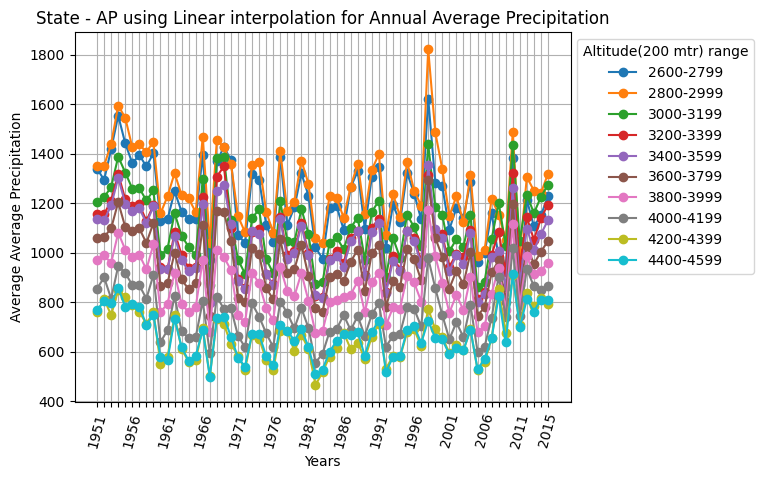

In [120]:
yearstoshow = [1,6]
doPlotting(yearstoshow)

SHOWING GRAPH YEARWISE


---State = AP --, interpoation = Linear-----


<Figure size 1200x2000 with 0 Axes>

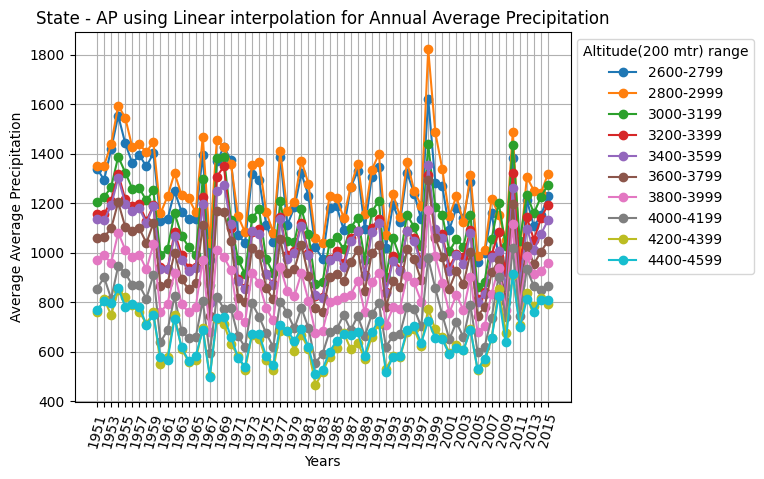

In [125]:
yearstoshow = [1,3,5,7,9]
doPlotting(yearstoshow)

# 8.Trend analysis

## Mann Kendall’s 
Doing for all at once

In [163]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import pandas as pd
import matplotlib.pyplot as plt
def DoMannkendallTest(df,State,interpolation):
    # Create a list to store the results
    results = []

    for altitude_range in df.index:
        # Filter the data frame to the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        values = values[1:]
        
        # Perform the Mann-Kendall test
        mann_kendall_test_result = mk.original_test(values)
        
        # Extract relevant test statistics
        tau = mann_kendall_test_result.Tau
        trend = mann_kendall_test_result.trend
        p_value = mann_kendall_test_result.p
        slope = mann_kendall_test_result.slope
        
        # Append the results to the list
        results.append([State,first_value,interpolation, trend, p_value])

    # Print the extracted state name
    # print('State = ',State)
    # print('Interpolation = ',interpolation)
    # Create a DataFrame from the results list
    # results_df = pd.DataFrame(results, columns=['Altitude Range', 'Interpolation', 'Trend', 'Tau', 'p-value', 'Slope'])
    results_df = pd.DataFrame(results, columns=['State','Altitude Range', 'Interpolation', 'Trend', 'p-value'])

    # Print the results table
    # print(results_df)
    return results_df

def TrendAnalysisMannKendall():
    typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
    State = ['AP.xlsx', 'HP.xlsx', 'J&K.xlsx', 'SK.xlsx', 'UK.xlsx']
    InterpolateRangeWise = './PrecipitaionAnalysis/InterpolateRangeWise'
    for statefile in State:
        result = pd.DataFrame()
        name, extensions = statefile.split('.')
        for interpolation in typeofInterpolation:
            print(f'---State = {name} --, interpoation = {interpolation}-----')
            dirname = interpolation + '200'
            __path__ = os.path.join(InterpolateRangeWise, dirname)
            if statefile in os.listdir(__path__):
                df = pd.read_excel(os.path.join(__path__, statefile))
                res = DoMannkendallTest(df, name,interpolation)
                result = pd.concat([result, res], ignore_index=True)
                result = pd.concat([result, pd.DataFrame({'Year': [np.nan], 'Trend': [np.nan]}).set_index('Year')], ignore_index=True)
                 # Add an empty row to separate results
                # result = pd.concat([result, pd.DataFrame(columns=result.columns)], ignore_index=True)
        SaveTestResults(result, name)
            
    
def SaveTestResults(result, name):
    path = './PrecipitaionAnalysis/MannKendallTestResults'
    if not os.path.exists(path):
        os.makedirs(path)
    file = os.path.join(path, name + 'MkTest.xlsx')
    # result.to_excel(file, index=False)
    result.to_excel(file, index=False, engine='openpyxl', sheet_name=f'MannKendallTest-{name}')


In [ ]:
TrendAnalysisMannKendall()

## Slope Test

In [172]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def slopeTest(df,state_name,interpolation):
    results = []
    for altitude_range in df.index:
        # Extract the precipitation values for the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        precipitation = values[1:]  # Extract precipitation data
        
        # Convert precipitation data and years to NumPy arrays
        precipitation = np.array(precipitation, dtype=float)
        years = np.array(df.columns[1:], dtype=int)
        # ipdb.set_trace()
        # Perform linear regression to calculate the slope
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, precipitation)
        # Find the p-value
        # Calculate t-statistic
        # t = slope / (std_err / np.sqrt(np.sum((years - np.mean(years))**2)))
        # p_value2 = 2 * (1 - stats.t.cdf(np.abs(t), len(years) - 2))
        if p_value < 0.05:
            result = "Reject"
        else:
            result = "Fail to reject"
        results.append([state_name, first_value,interpolation,  p_value, result])

    # Print the extracted state name
    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results, columns=['State','Altitude Range', 'Interpolation', 'p-value','Result'])
    return results_df

   
def TrendAnalysisSlopeTest():
    typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
    State = ['AP.xlsx', 'HP.xlsx', 'J&K.xlsx', 'SK.xlsx', 'UK.xlsx']
    InterpolateRangeWise = './PrecipitaionAnalysis/InterpolateRangeWise'
    for statefile in State:
        result = pd.DataFrame()
        name, extensions = statefile.split('.')
        for interpolation in typeofInterpolation:
            print(f'---State = {name} --, interpoation = {interpolation}-----')
            dirname = interpolation + '200'
            __path__ = os.path.join(InterpolateRangeWise, dirname)
            if statefile in os.listdir(__path__):
                df = pd.read_excel(os.path.join(__path__, statefile))
                res = slopeTest(df, name,interpolation)
                result = pd.concat([result, res], ignore_index=True)
                result = pd.concat([result, pd.DataFrame({'Result': [np.nan]})], ignore_index=True)
                 # Add an empty row to separate results
                # result = pd.concat([result, pd.DataFrame(columns=result.columns)], ignore_index=True)
        SaveTestResults(result, name)
            
    
def SaveTestResults(result, name):
    path = './PrecipitaionAnalysis/SlopeSenTestResults'
    if not os.path.exists(path):
        os.makedirs(path)
    file = os.path.join(path, name + 'SlopeTest.xlsx')
    # result.to_excel(file, index=False)
    result.to_excel(file, index=False, engine='openpyxl', sheet_name=f'SlopeSenTest-{name}')


In [ ]:
TrendAnalysisSlopeTest()

# 10. Showing Drop Down Menu for precipitation


In [1]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
from openpyxl import Workbook
import os
import ipdb
from scipy.interpolate import griddata
from sklearn.neighbors import KNeighborsRegressor
import time
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output, display_html, HTML
import logging
from ipywidgets import Dropdown
# Ignore FutureWarnings
from tabulate import tabulate
import pymannkendall as mk
import scipy.stats as stats
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore", category=FutureWarning)
from PIL import Image
import textwrap

In [2]:
def PrintSenSlopeTest(df, state_name, interpolation, YearRange, Season):
    results = []
    YearRange = [str(year) for year in YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted} years timeseries)'  # Get the year range
    df = df.loc[:, YearRange]
    for altitude_range in df.index:
        # Extract the precipitation values for the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        precipitation = values[1:]  # Extract precipitation data

        # Convert precipitation data and years to NumPy arrays
        precipitation = np.array(precipitation, dtype=float)
        years = np.array(df.columns[1:], dtype=int)
        # Perform linear regression to calculate the slope
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            years, precipitation)
        # Find the p-value
        # Calculate t-statistic
        # t = slope / (std_err / np.sqrt(np.sum((years - np.mean(years))**2)))
        # p_value2 = 2 * (1 - stats.t.cdf(np.abs(t), len(years) - 2))
        if p_value < 0.05:
            result = "Reject"
        else:
            result = "Fail to reject"
        results.append([state_name, altitude_range, year_range,
                       interpolation,  p_value, slope, result])

    # Print the extracted state name
    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results, columns=[
                              'State', 'Altitude Range','Year Range', 'Interpolation', 'p-value', 'Slope', 'Result'])
    print(tabulate(results_df, headers='keys',
          tablefmt='fancy_grid', showindex=False))
     # Print the DataFrame beautifully
    
    # Hypothesis testing outcomes
    outcomes = {
        "Reject the null hypothesis": "This means that the data provides sufficient evidence to conclude that the null hypothesis is false.",
        "Fail to reject the null hypothesis": "This means that the data does not provide sufficient evidence to conclude that the null hypothesis is false.",
    }

    # Print formatted outcomes
    for outcome, description in outcomes.items():
        formatted_text = textwrap.fill(description, width=60)  # Adjust the width as needed
        print(f"{outcome}:\n{formatted_text}\n")


def PrintMankendallTest(df, State, interpolation, YearRange, Season):
    # Create a list to store the results

    results = []
    # Change YearRange to string as df.columns is string
    # modify the df now
    YearRange = [str(year) for year in YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted} years timeseries)'
    df = df.loc[:, YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted})'  # Get the year range
    for altitude_range in df.index:
        # Filter the data frame to the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        values = values[1:]

        # Perform the Mann-Kendall test
        mann_kendall_test_result = mk.original_test(values)

        # Extract relevant test statistics
        tau = mann_kendall_test_result.Tau
        trend = mann_kendall_test_result.trend
        p_value = mann_kendall_test_result.p
        slope = mann_kendall_test_result.slope
        z_test_statics = mann_kendall_test_result.z

        tau = round(float(tau), 5)
        p_value = round(float(p_value), 5)
        slope = round(float(slope), 5)

        # Append the results to the list
        results.append([State, altitude_range, year_range, interpolation, p_value, z_test_statics, trend])

    # results_df = pd.DataFrame(results, columns=['Altitude Range', 'Interpolation', 'Trend', 'Tau', 'p-value', 'Slope'])
    results_df = pd.DataFrame(results, columns=[
                              'State', 'Altitude Range', 'Year Range', 'Interpolation', 'p-value', 'z_test_statics' ,'Trend'])
    print(tabulate(results_df, headers='keys',
          tablefmt='fancy_grid', showindex=False))
    outcomes = {
                'p-value < 0.05, z_test_statics > 0' :	'Statistically significant increasing trend',
                'p-value < 0.05, z_test_statics < 0' :	'Statistically significant decreasing trend',
                'p-value > 0.05' :	'Fail to reject the null hypothesis of no trend',
                 'Note ': 'It is a non-parametric measure, so it does not make any assumptions about the distribution of the data.'
                }
    for outcome, description in outcomes.items():
        formatted_text = textwrap.fill(description, width=60)  # Adjust the width as needed
        print(f"{outcome}:\n{formatted_text}\n")
def ShowGraphTemp(df, State, interpolation, x_ticks, YearRange, Season):
    # Set the 'Altitude Range' column as the index
    print(Season)
    if 'Altitude Range' in df.columns:
        df.set_index('Altitude Range', inplace=True)
    elif 'Altitude range' in df.columns:
        df.set_index('Altitude range', inplace=True)
    # Set the figure size before creating the plot
    YearRange = [str(year) for year in YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted} years timeseries)'
    plt.figure(figsize=(12, 20))
    # Create a line plot
    ax = df.T.plot(kind='line', marker='o')
    extrayear = '2015'
    # Customize the plot (labels, title, etc.)
    plt.xlabel('Years of Time Series')
    plt.ylabel('Average Average Precipitation')

    plt.title(
        f'State - {State} using {interpolation} interpolation for Annual Average Precipitation\n{year_range}')

    # Customize the x-axis tick labels to emphasize every 10 years
    x_values = list(df.columns)
    # x_labels = [year if int(year) % 10  in yeartoshow else year for year in x_values]
    x_labels = [year if int(year[-1]) % 10 in x_ticks or year ==
                extrayear else '' for year in x_values]
    plt.xticks(range(len(x_values)), x_labels, rotation=75)
    # Move the legend outside the plot to the upp   er right
    plt.legend(title='Altitude(200 mtr) range',
               loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.grid(True)
    # plt.tight_layout()
    plt.show()


In [3]:
def getresults(results, MinMaxRange):
    year_wise_data = results.iloc[0:, 0:]
    result_mean = year_wise_data.mean().to_frame().T
    result_mean.insert(0, 'Altitude Range', MinMaxRange)
    result_mean = result_mean.set_index('Altitude Range')
    return result_mean


def getmaxminAltitudeVAlues(df):

    minAltitude = df['Altitude Range'][0].split('-')[0]
    maxAltitude = df['Altitude Range'][df.shape[0]-1].split('-')[1]
    MinMaxRange = f'{minAltitude}-{maxAltitude}'
    AltitudeRange = df['Altitude Range'].values
    return MinMaxRange, AltitudeRange


def DoComputations(state, interpolation, x_ticks, YearsRange, Season):
    YearsRange = [str(year) for year in YearsRange]
    interpolatoinRangeWisePath = './PrecipitaionAnalysis/InterpolateRangeWise'
    name = state
    _path_ = interpolatoinRangeWisePath + f'/{interpolation}200'
    # ShowingBy altitude Range
    print('Showing by various altitude range')
    logging.info(f'---State = {state} --, interpoation = {interpolation}-----')
    df = pd.read_excel(os.path.join(_path_, f'{state}.xlsx'))
    selected_columns = ['Altitude Range'] + [str(year) for year in YearsRange]
    df = df[selected_columns]
    df_modified = df
    df = df.set_index('Altitude Range')

    ShowGraphTemp(df, state, interpolation, x_ticks, YearsRange, Season)
    logging.info(f'---Plotted graph for {name}-{interpolation}----')

    print('PrecipitaionAnalysis  Showing Mankendall test for state', state)
    PrintMankendallTest(df, state, interpolation, YearsRange, Season)
    logging.info(f'---Showing Sen Slope test for {name}-{interpolation}-----')

    print(
        f'PrecipitaionAnalysis ---Showing Sen Slope test for {name}-{interpolation}- ----')
    PrintSenSlopeTest(df, state, interpolation, YearsRange, Season)

    logging.info('')
    print(f'Shoing Complete {state} Precipitaion  graph and analysis')
    MinMaxRange, altitude_range = getmaxminAltitudeVAlues(df_modified)

    # now get year of results
    # df.insert(0, 'Altitude Range', altitude_range)

    # Now show complete analysis for all altitude range
    modified_df = getresults(df_modified, MinMaxRange)
    ShowGraphTemp(modified_df, state, interpolation,
                  x_ticks, YearsRange, Season)
    logging.info(f'---Plotted graph for {name}-{interpolation}-Annual----')

    print('Showing Mankendall test for whole state', state)
    PrintMankendallTest(modified_df, state, interpolation, YearsRange, Season)
    logging.info(
        f'---Showing Sen Slope test for {name}-{interpolation}-Annual----')

    print(f'---Showing Sen Slope test for {name}-{interpolation}-Annual----')
    PrintSenSlopeTest(modified_df, state, interpolation, YearsRange, Season)



In [4]:

def flatten_list(input_list):
    result = []
    for item in input_list:
        if isinstance(item, tuple):
            result.extend(item)
        else:
            result.append(item)
    return result
log_filename = './PrecipitaionAnalysis/LOGFilesPrecip/10_PlottingPrecipitationTheGraph.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Output widget for displaying results
output = widgets.Output()
selected_state = None
selected_analysis_type = None
selected_months = None
selected_interpolation = None
selected_years_to_show = None
selected_years_to_extract = None
selected_season = None
Months = [] 
Analysis_type = None
Season = 'Monthly'
def on_submit_button_click(b):
    with output:
        clear_output()  # Clear previous output

        global selected_state
        global selected_analysis_type
        global selected_months
        global selected_interpolation
        global selected_years_to_show
        global selected_years_to_extract
        global Season
        global Analysis_type
        selected_state = state_dropdown.value
        selected_interpolation = interpolation_dropdown.value
        selected_years_to_show = yearstoshow_Multioption.value
        selected_years_to_extract = yearstoextract_slider.value
        
        # Log the selected values
        logging.info(f'States: {selected_state}')
        logging.info(f'Season: {Season}')
        logging.info(f'Interpolation: {selected_interpolation}')
        logging.info(f'Years to Show: {selected_years_to_show}')
        logging.info(f'Years to Extract: {selected_years_to_extract}')
        logging.info('') 

        print('Precipitation analysis for annully mean, values are as logged.')
        print(f'States: {selected_state}')
        print(f'Season: {Season}')
        print(f'Interpolation: {selected_interpolation}')
        print(f'Years to Show: {selected_years_to_show}')
        print(f'Years to Extract: {selected_years_to_extract}')
        #  with output:
        #     clear_output()
        state, Analysis_type,  Interpolation, ModVal = selected_state, selected_analysis_type ,selected_interpolation, flatten_list(selected_years_to_show)
        Years = list(range(selected_years_to_extract[0], selected_years_to_extract[1]+1))

        DoComputations(state, Interpolation, ModVal, Years, Season)

def clear_and_display(widget):
    global Season
    with output:
        clear_output()
        display(widget)

# Create dropdown widget for states
state_dropdown = widgets.Dropdown(
    options=['Select State','UK', 'J&K', 'AP', 'HP', 'SK'],
    value='Select State',
    description='States:'
)
#
interpolation_dropdown = widgets.Dropdown(
    options=['Select Interpolation','Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW'],
    value='Select Interpolation',
    description='Interpolation:'
)

# Create dropdown widget for type of analysis
analysis_dropdown = widgets.Dropdown(
    options=['SelectAnalysis','Monthly', 'Annually', 'Seasonally'],
    value='SelectAnalysis',
    description='Type of Analysis:'
)


# Create a multi-option widget for 'yearstoshow_Multioption'
yearstoshow_Multioption = widgets.SelectMultiple(
    options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    value=[1,5],  # You can set the default selected options here
    description='Years to Show:'
)


yearstoextract_slider = widgets.IntRangeSlider(
    value=[1951, 2015],  # Set initial range as needed
    min=1951,             # Set minimum and maximum year values as needed
    max=2015,
    step=1,
    description='Years to Extract:'
)

# Attach the click event handler to the button
submit_button = widgets.Button(description='Submit')
submit_button.on_click(on_submit_button_click)

input_widgets = widgets.VBox([
    state_dropdown, 
    # month_dropdown, 
    interpolation_dropdown, 
    yearstoshow_Multioption, 
    yearstoextract_slider, 
    submit_button
])
 
# Display the input widgets

# Display the output area
display(input_widgets)
display(output)

def on_clear_button_click(b):
    """Resets the form and clears the output."""

    # Clear the input values
    state_dropdown.value = 'Select State'
    interpolation_dropdown.value = 'Select Interpolation'
    yearstoshow_Multioption.value = [1, 5]
    yearstoextract_slider.value = [1951, 2015]

    # Clear the output
    with output:
        clear_output()
# Add a clear button
clear_button = widgets.Button(description='Clear')

# Attach the click event handler to the clear button
clear_button.on_click(on_clear_button_click)

# Display the clear button
display(clear_button)

Output()

Button(description='Clear', style=ButtonStyle())